In [1]:
import sys
sys.dont_write_bytecode = True

import numpy as np  
import pandas as pd
import datetime
import graphviz
import gurobipy as gp
from gurobipy import GRB
sys.path.append("simulator")
from simulator import simulator as sim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
import matplotlib.pyplot as plt

random.seed(1234)

def trunc(temp): # utility function for node naming
    st = temp.find("(")
    temp = temp[:st]
    return temp

application = "linear" # "linear", "three_depth"
if application == "linear":
    sim.linear_topology_application()
elif application == "three_depth":
    sim.three_depth_application()
else:
    print("ERROR: Unsupported application, ", application)

User capacity: 99999999
A capacity: 50.0
B capacity: 33.333333333333336
C capacity: 200.0
- num_replica_for_cluster_0
	- User: 1
	- A: 2
	- B: 2
	- C: 2
- num_replica_for_cluster_1
	- User: 1
	- A: 2
	- B: 2
	- C: 2
===== print_service_and_replica =====
User
	cluster 0 User_0(node[0000])
	cluster 1 User_1(node[1000])
A
	cluster 0 A_0(node[0000])
	cluster 0 A_2(node[0000])
	cluster 1 A_1(node[1000])
	cluster 1 A_3(node[1000])
B
	cluster 0 B_0(node[0000])
	cluster 0 B_2(node[0000])
	cluster 1 B_1(node[1000])
	cluster 1 B_3(node[1000])
C
	cluster 0 C_0(node[0000])
	cluster 0 C_2(node[0000])
	cluster 1 C_1(node[1000])
	cluster 1 C_3(node[1000])

replica_for_cluster_0[User], User_0(node[0000])
replica_for_cluster_1[User], User_1(node[1000])


## Predict the Service times

We will utilize a simple prediction model to estimate the service time for each individual service. This estimation will be based on inputs such as requests per second and CPU utilization. Service times of each service have their own unique relationship with requests per second, cpu utilization and other variables. The model assumes that the required telemetry inputs are collected from multiple clusters and grouped by service and cluster for model fitting and prediction. 
All variables in this model are server-side not client-side.

Model
- Linear regression or polynomial regression

Input
- $service\ name$: name of a service
- $cluster\ id$: uid of a cluster
- $rps$ : request per second
- $cpu$: cpu utilization of pod
- $mem$ : memory utilization of pod

Output
- $service\ time$: from the time that a request arrives at service A to the time that a request leaves service A.
    - service time includes service execution time and queueing 
    - This model assumes that service time can be predicted by request per second, cpu utilization and memory utilization.

This model has nothing to do with communication between services or network latency.

Note that terms like 'service time,' 'compute time,' and 'compute latency' are all used interchangeably.

<!-- ### Current model
- Assumption
  - The prediction model is polynomial regressor with the degree of 2.
  - Each service has 100 data point to be used for model fitting. -->


## Problem formulation
- Application will be represented in a form of graph.

- Node
  - Format: "$\{service\ name\}\_\{replica\ id\}\_\{start/end\}$
  - Start node
    - the time that a request arrives at service A
    - e.g.: A_0_start, B_0_start
  - End node
    - the time that a request leaves service A
    - e.g.: A_0_end, B_0_end
  - 
    - compute time
      - start_node - end_node
        - e.g.: A_0_start - A_0_end, B_1_start - B_1_end
      - end_node - start_node
        - e.g.: A_0_end - B_0_start, A_0_end - B_1_start

- Edge
  - Edges represents either compute time of a service or network latency between replicas.
  - Compute edge
    - Service time (compute time)
    - This is the one that will be predicted by the above prediction model.
    - [start_node]--[end_node]
      - e.g.: A_0_start - A_0_end, B_1_start - B_1_end
  - Network edge
    - Network latecny
    - [end_node]--[start_node]
      - e.g.: A_0_end - B_0_start, A_0_end - B_1_start

- Latency = (compute time or network latency) * (number of requests that flows through the edge)

- Objective
  - Minimize the sum of all latency
  - <-> Minimize average latency for a batch of requests. 
  - Note that it is not identical with balancing loads between clusters.

In [2]:
# YOU MUST EXECUTE THIS CELL.
NUM_REQUEST = [500, 100]
TOTAL_NUM_REQUEST = sum(NUM_REQUEST)

In [3]:
print(sim.dag.graph)
sim.dag.print_dependency()

{<simulator.simulator.Service object at 0x7fb422380a90>: [{'service': <simulator.simulator.Service object at 0x7fb42230c6d0>, 'weight': 20}], <simulator.simulator.Service object at 0x7fb42230c6d0>: [{'service': <simulator.simulator.Service object at 0x7fb3f0118bb0>, 'weight': 10}], <simulator.simulator.Service object at 0x7fb3f0118bb0>: [{'service': <simulator.simulator.Service object at 0x7fb421af9610>, 'weight': 100}]}
========== DAG ==========
User->A, 20
A->B, 10
B->C, 100


8400
8400
8400
8400


,service_name,rps,compute_time
"(User_0_start, User_0_end)",User,0,0
"(User_0_start, User_0_end)",User,1,0
"(User_0_start, User_0_end)",User,2,0
"(User_0_start, User_0_end)",User,3,0
"(User_0_start, User_0_end)",User,4,0
...,...,...,...
"(C_3_start, C_3_end)",C,595,2478185
"(C_3_start, C_3_end)",C,596,2486522
"(C_3_start, C_3_end)",C,597,2494873
"(C_3_start, C_3_end)",C,598,2503238


unique_service_name:  ['User', 'A', 'B', 'C']
Service User
- Coef: [0. 0. 0.]
- R^2: 1.0
Service A
- Coef: [ 0.00000000e+00 -4.78905804e-12  7.00000000e+00]
- R^2: 1.0
Service B
- Coef: [ 0.00000000e+00 -6.41975362e-12  1.00000000e+01]
- R^2: 1.0
Service C
- Coef: [ 0.00000000e+00 -4.78905804e-12  7.00000000e+00]
- R^2: 1.0


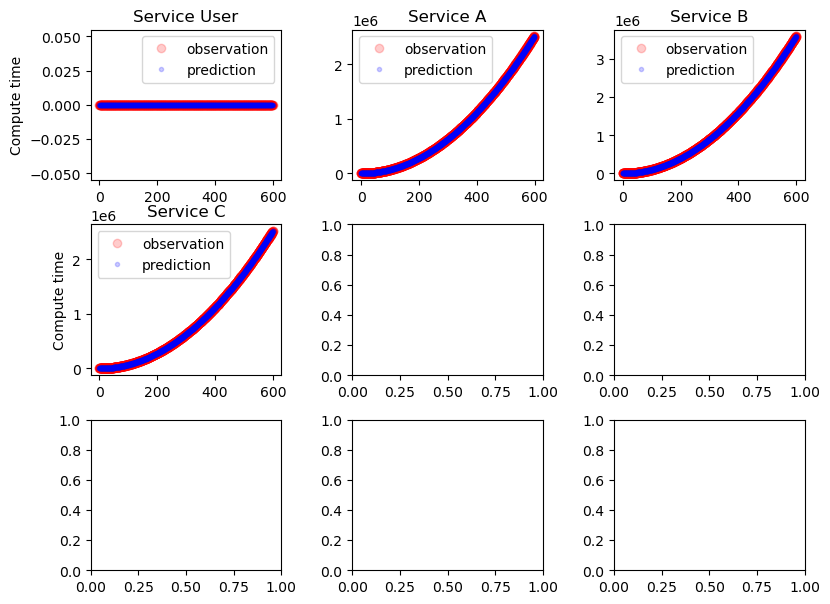

In [5]:
svc_name_list = list()

compute_arc_var_name = list()
per_service_compute_arc = dict()
for repl in sim.dag.all_replica:
    # if repl.service.name != "User":
    var_name = (trunc(repl.to_str())+"_start", trunc(repl.to_str())+"_end")
    compute_arc_var_name.append(var_name)
    if repl.service.name not in per_service_compute_arc:
        per_service_compute_arc[repl.service.name] = list()
    per_service_compute_arc[repl.service.name].append(var_name)
    svc_name_list.append(repl.service.name)

#################################################################################################
# network_arc_var_name = list()
# for parent_repl in sim.dag.child_replica:
#     for child_svc in sim.dag.child_replica[parent_repl]:
#         child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
#         for child_repl in child_repl_list:
#             if parent_repl.service.name == "User":
#                 var_name = ("src_*_*", trunc(child_repl.to_str())+"_start")
#                 if var_name not in network_arc_var_name:
#                     network_arc_var_name.append(var_name)
#             else:
#                 var_name = (trunc(parent_repl.to_str())+"_end",  trunc(child_repl.to_str())+"_start")
#                 if var_name not in network_arc_var_name:
#                     network_arc_var_name.append(var_name)
#             if sim.dag.is_leaf(child_repl.service):
#                 var_name = (trunc(child_repl.to_str())+"_end", "dst_*_*")
#                 if var_name not in network_arc_var_name:
#                     network_arc_var_name.append(var_name)
                    
network_arc_var_name = list()
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                var_name = ("src_*_*", trunc(parent_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
                var_name = (trunc(parent_repl.to_str())+"_end", trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            else:
                var_name = (trunc(parent_repl.to_str())+"_end",  trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            if sim.dag.is_leaf(child_repl.service):
                var_name = (trunc(child_repl.to_str())+"_end", "dst_*_*")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
#################################################################################################

true_function_degree = 2
regressor_degree = 2
num_data_point = TOTAL_NUM_REQUEST # It needs to observe RPS up to TOTAL_NUM_REQUEST since in the worst case all requests could be routed to one replica of a service.
randomize_factor = 100
x_rps = list()
x_service_name = list()
y_compute_time = list()

x_repl_name = list()
for i in range(len(compute_arc_var_name)):
    x_rps += list(np.arange(0,num_data_point))
    x_repl_name += [compute_arc_var_name[i]] * num_data_point
    x_service_name += [svc_name_list[i]] * num_data_point

# for elem in compute_arc_var_name:
    for j in range(num_data_point):
        svc_name = compute_arc_var_name[i][0].split("_")[0]
        slope = abs(hash(svc_name)%10)+1
        # print("slope({}) = {}".format(svc_name, slope))
        # print(svc_name)
        if svc_name == "User":
            y_compute_time.append(0)
        else:
            y_compute_time.append(pow(x_rps[j],true_function_degree)*slope + 10)

print(len(x_service_name))
print(len(x_rps))
print(len(y_compute_time))
print(len(x_repl_name))

compute_time_observation = pd.DataFrame(
    data={
        "service_name": x_service_name,
        "rps": x_rps, 
        "compute_time": y_compute_time,
    },
    index=x_repl_name
)
# with pd.option_context('display.max_colwidth', None):
#     with pd.option_context('display.max_rows', None):
#         print("<compute_time_observation df>")
#         print(compute_time_observation.shape)
display(compute_time_observation)

## Per-service rps-to-compute time modeling.
unique_service_name = list(compute_time_observation["service_name"].unique())
# unique_service_name.remove("User")
print("unique_service_name: ", unique_service_name)

num_subplot_row = 3
num_subplot_col = 3
fig, (plot_list) = plt.subplots(num_subplot_row, num_subplot_col, figsize=(8,6))
fig.tight_layout()
# print(plot_list)
# print(plot_list[0])
# print(plot_list[0][0])

max_compute_time = dict()
idx = 0
regressor_dict = dict()
for svc_name in unique_service_name:
    temp_df = compute_time_observation[compute_time_observation["service_name"] == svc_name]
    # X = temp_df[["service_name", "rps"]]
    X = temp_df[["rps"]]
    y = temp_df["compute_time"]
    max_compute_time[svc_name] = max(y)
    # print("max(y): ", max(y))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, random_state=1
    )
    feat_transform = make_column_transformer(
        # (StandardScaler(), ["rps"]),
        ("passthrough", ["rps"]),
        verbose_feature_names_out=False,
        remainder='drop'
    )
    if regressor_degree == 1:
        regressor_dict[svc_name] = make_pipeline(feat_transform, LinearRegression())
        regressor_dict[svc_name].fit(X_train, y_train)
    elif regressor_degree > 1:
        poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
        regressor_dict[svc_name] = make_pipeline(feat_transform, poly, LinearRegression())
        regressor_dict[svc_name].fit(X_train, y_train)
    print("Service {}".format(svc_name))
    print("- Coef: {}".format(regressor_dict[svc_name]["linearregression"].coef_))
    ## Run prediction and compare it with the ground truth to see how accurate the trained model is
    y_pred = regressor_dict[svc_name].predict(X_test)
    print(f"- R^2: {np.round(r2_score(y_test, y_pred),5)}")
    
    row_idx = int(idx/num_subplot_col)
    col_idx = idx%num_subplot_col
    # print(row_idx, col_idx)
    plot_list[row_idx][col_idx].plot(X["rps"], y, 'ro', label="observation", alpha=0.2)
    plot_list[row_idx][col_idx].plot(X["rps"], regressor_dict[svc_name].predict(X), 'b.', label="prediction", alpha=0.2)
    plot_list[row_idx][col_idx].legend()
    plot_list[row_idx][col_idx].set_title("Service " + svc_name)
    if row_idx == num_subplot_row-1:
        plot_list[row_idx][col_idx].set_xlabel("RPS")
    if col_idx == 0:
        plot_list[row_idx][col_idx].set_ylabel("Compute time")
    idx += 1

## Optimize latency for num of requests
Notation for the formulation of the mathematical optimization model.

### Decision Variables
A decision variable stands for an unknown variable in an optimization problem.

src and dst in $X^{dst}_{src}$ notation is a edge from src node to dst node.

- $rps^{dst}_{src}$: number of request that flows from src to dst

- $compute\ time^{dst}_{src}$: compute time between $src$ and $dst$ in gurobi $arcs$ variable. 
  - It is **constrainted** by the above prediction model.
  - $compute\ time = model(r, c, m, s)$: predicted service time of service $s$ when rps, cpu util and memory util are $r$, $c$ and $m$ respectively.

- $network\ latency^{dst}_{src}$: network latency between $src$ and $dst$ in gurobi $arcs$ variable. 
  - It is fixed value.
  - Should it be RTT or one-way latency?
  - 
### lower/upper bound for decision variables
- $r^s_{min}$: minimum rps for service $s$
- $r^s_{max}$: maximum rps for service $s$
- $c^s_{min}$: minimum cpu util for service $s$
- $c^s_{max}$: maximum cpu util for service $s$
- $m^s_{min}$: minimum memory util for service $s$
- $m^s_{max}$: maximum memory util for service $s$

### Defining variables using Gurobi pandas

The main purpose of compute_time_data and network_arc_var_name dataframe is to define the gurobi variable later.

In [19]:
min_rps = 0
max_rps = max(x_rps)

min_network_egress_cost = list()
max_network_egress_cost = list()
for src_repl, dst_repl in network_arc_var_name:
    src_svc = src_repl.split("_")[0] # A
    dst_svc = dst_repl.split("_")[0] # B
    if src_svc == "src":
        min_network_egress_cost.append(0)
        max_network_egress_cost.append(0)
    elif dst_svc == "dst":
        min_network_egress_cost.append(0)
        max_network_egress_cost.append(0)
    else:
        from_idx = int(src_repl.split("_")[1])
        to_idx = int(dst_repl.split("_")[1])
        # local routing
        if from_idx%2 == to_idx%2:
            min_network_egress_cost.append(0) # no egress charge on local routing
            max_network_egress_cost.append(0)
        # remote routing
        else:
            min_network_egress_cost.append(sim.dag.weight_graph[src_svc][dst_svc])
            max_network_egress_cost.append(sim.dag.weight_graph[src_svc][dst_svc])
                
network_egress_cost_data = pd.DataFrame(
    data={
        "min_network_egress_cost": min_network_egress_cost,
        "max_network_egress_cost": max_network_egress_cost,
        # "min_rps":[min_rps]*len(network_arc_var_name),
        # "max_rps":[max_rps]*len(network_arc_var_name),
    },
    index=network_arc_var_name
)


min_compute_egress_cost = list()
max_compute_egress_cost = list()
for src_repl, dst_repl in compute_arc_var_name:
    # compute edge does not involve any networking
    min_compute_egress_cost.append(0)
    max_compute_egress_cost.append(0)
                
compute_egress_cost_data = dict()
for svc_name in unique_service_name:
    compute_egress_cost_data[svc_name] = pd.DataFrame(
        data={
            # "min_rps":[min_rps] * len(per_service_compute_arc[svc_name]),
            # "max_rps":[max_rps] * len(per_service_compute_arc[svc_name]),
            "min_compute_egress_cost": [0] * len(per_service_compute_arc[svc_name]),
            "max_compute_egress_cost": [0] * len(per_service_compute_arc[svc_name]),
        },
        index=per_service_compute_arc[svc_name]
    )

display(compute_egress_cost_data["A"])
display(network_egress_cost_data)

,min_compute_egress_cost,max_compute_egress_cost
"(A_0_start, A_0_end)",0,0
"(A_2_start, A_2_end)",0,0
"(A_1_start, A_1_end)",0,0
"(A_3_start, A_3_end)",0,0


,min_network_egress_cost,max_network_egress_cost
"(src_*_*, User_0_start)",0,0
"(User_0_end, A_0_start)",0,0
"(User_0_end, A_2_start)",0,0
"(User_0_end, A_1_start)",20,20
"(User_0_end, A_3_start)",20,20
"(A_0_end, B_0_start)",0,0
"(A_0_end, B_2_start)",0,0
"(A_0_end, B_1_start)",10,10
"(A_0_end, B_3_start)",10,10
"(A_2_end, B_0_start)",0,0


In [20]:
min_rps = 0
max_rps = max(x_rps)
compute_time_data = dict()
for svc_name in unique_service_name:
    compute_time_data[svc_name] = pd.DataFrame(
        data={
            "min_rps":[min_rps] * len(per_service_compute_arc[svc_name]),
            "max_rps":[max_rps] * len(per_service_compute_arc[svc_name]),
            "min_compute_time": [0] * len(per_service_compute_arc[svc_name]),
            "max_compute_time": [max_compute_time[svc_name]] * len(per_service_compute_arc[svc_name]),
        },
        index=per_service_compute_arc[svc_name]
    )

min_network_latency = list()
max_network_latency = list()
for src_repl, dst_repl in network_arc_var_name:
    src_svc = src_repl.split("_")[0]
    dst_svc = dst_repl.split("_")[0]
    if src_svc == "src":
        min_network_latency.append(0)
        max_network_latency.append(0)
    elif dst_svc == "dst":
        min_network_latency.append(0)
        max_network_latency.append(0)
    else:
        from_idx = int(src_repl.split("_")[1])
        to_idx = int(dst_repl.split("_")[1])
        # Network latency for local routing
        if from_idx%2 == to_idx%2:
            min_network_latency.append(sim.NetworkLatency().same_rack)
            max_network_latency.append(sim.NetworkLatency().same_rack)
        # Network latency for remote routing
        else:
            min_network_latency.append(sim.NetworkLatency().far_inter_region)
            max_network_latency.append(sim.NetworkLatency().far_inter_region)

network_latency_data = pd.DataFrame(
    data={
        # "service_name":network_arc_var_name,
        "min_rps":[min_rps]*len(network_arc_var_name),
        "max_rps":[max_rps]*len(network_arc_var_name),
        "min_network_latency": min_network_latency,
        "max_network_latency": max_network_latency,
    },
    index=network_arc_var_name
)

print("compute_time_data<\"A\">")
display(compute_time_data["User"])
display(compute_time_data["A"])
with pd.option_context('display.max_rows', None):
    print("network_latency_data")
    display(network_latency_data)

compute_time_data<"A">


,min_rps,max_rps,min_compute_time,max_compute_time
"(User_0_start, User_0_end)",0,599,0,0
"(User_1_start, User_1_end)",0,599,0,0


,min_rps,max_rps,min_compute_time,max_compute_time
"(A_0_start, A_0_end)",0,599,0,2511617
"(A_2_start, A_2_end)",0,599,0,2511617
"(A_1_start, A_1_end)",0,599,0,2511617
"(A_3_start, A_3_end)",0,599,0,2511617


network_latency_data


,min_rps,max_rps,min_network_latency,max_network_latency
"(src_*_*, User_0_start)",0,599,0.0,0.0
"(User_0_end, A_0_start)",0,599,0.5,0.5
"(User_0_end, A_2_start)",0,599,0.5,0.5
"(User_0_end, A_1_start)",0,599,30.0,30.0
"(User_0_end, A_3_start)",0,599,30.0,30.0
"(A_0_end, B_0_start)",0,599,0.5,0.5
"(A_0_end, B_2_start)",0,599,0.5,0.5
"(A_0_end, B_1_start)",0,599,30.0,30.0
"(A_0_end, B_3_start)",0,599,30.0,30.0
"(A_2_end, B_0_start)",0,599,0.5,0.5


### gppd.add_vars

gppd.add_vars will add multiple new variables to the model. These variables will have the same name of the index given as a second argument in add_vars method. It returns pandas Series object which is composed of a list of gurobi variables with index.

The second argument of gppd.add_vars method is "pandas_obj" – A pandas Index, Series, or DataFrame.

In [21]:
model = gp.Model('RequestRouting')

# Add variables for the regression
compute_time = dict()
compute_rps = dict()
for svc_name in unique_service_name:
    compute_time[svc_name] = gppd.add_vars(model, compute_time_data[svc_name], name="compute_time", lb="min_compute_time", ub="max_compute_time")
    compute_rps[svc_name] = gppd.add_vars(model, compute_time_data[svc_name], name="rps_for_compute_edge", lb="min_rps", ub="max_rps")
model.update()

## gurobi_ml.add_predictor_constr

gurobi_ml.add_predictor_constr simply adds constraint to the model. What makes add_predictor_constr different from normal addConstr(s) is whether the constraint is in the form of ml model or not.

In this example, we utilize linear/poly regressor model to predict compute time. The variables representing compute time is "compute time" which is y value of the model. We already train the regressor model which has "service_name", "rps", "cpu", "mem" as column name of input features and "compute_time" as column name of y value in dataframe.

"m_feats" is dataframe object and this dataframe **must** have the same index as "compute time" gurobi variable to be used in add_predictor. The index of "compute time" is compute_arc_var_name ("tuple(start_node, end_node)" of the same service as defined earlier). The index of m_feats is "compute_arc_var_name" which is basically same as the index of "compute time" variable.
"m_feats" will be fed into the constraint as input variable of the model. "compute time" is the output variable of the model.

reference: https://gurobi-machinelearning.readthedocs.io/en/stable/api/AbstractPredictorConstr.html

In [22]:
m_feats = dict()
for svc_name in unique_service_name:
    m_feats[svc_name] = pd.DataFrame(
        data={
            "rps": compute_rps[svc_name],
        },
        index=per_service_compute_arc[svc_name]
    )
    # print("<m_feats>")
    # display(m_feats)
    # print("<compute_time[svc_name]>")
    # display(compute_time[svc_name])
    pred_constr = add_predictor_constr(model, regressor_dict[svc_name], m_feats[svc_name], compute_time[svc_name])
    if svc_name == "A":
        pred_constr.print_stats()
        
model.update()

Model for pipe0:
12 variables
4 constraints
12 quadratic constraints
Input has shape (4, 1)
Output has shape (4, 1)

Pipeline has 3 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans             (4, 1)            0            0            0            0

poly_feat             (4, 3)           12            0           12            0

lin_reg               (4, 1)            0            4            0            0

--------------------------------------------------------------------------------


In [23]:
network_latency = gppd.add_vars(model, network_latency_data, name="network_latency", lb="min_network_latency", ub="max_network_latency")
network_rps = gppd.add_vars(model, network_latency_data, name="rps_for_network_edge", lb="min_rps", ub="max_rps")
model.update()
# print(type(network_latency))
# print(network_latency)
# print(network_rps)

In [12]:
compute_time_data["A"]

,min_rps,max_rps,min_compute_time,max_compute_time
"(A_0_start, A_0_end)",0,599,0,2511617
"(A_2_start, A_2_end)",0,599,0,2511617
"(A_1_start, A_1_end)",0,599,0,2511617
"(A_3_start, A_3_end)",0,599,0,2511617


In [24]:
network_egress_cost = gppd.add_vars(model, network_egress_cost_data, name="network_egress_cost", lb="min_network_egress_cost", ub="max_network_egress_cost")

compute_egress_cost = dict()
for svc_name in unique_service_name:
    compute_egress_cost[svc_name] = gppd.add_vars(model, compute_egress_cost_data[svc_name], name="compute_egress_cost", lb="min_compute_egress_cost", ub="max_compute_egress_cost")
model.update()
with pd.option_context('display.max_colwidth', None):
    print(network_egress_cost)
    print(compute_egress_cost)

(src_*_*, User_0_start)    <gurobi.Var network_egress_cost[('src____',_'User_0_start')]>
(User_0_end, A_0_start)    <gurobi.Var network_egress_cost[('User_0_end',_'A_0_start')]>
(User_0_end, A_2_start)    <gurobi.Var network_egress_cost[('User_0_end',_'A_2_start')]>
(User_0_end, A_1_start)    <gurobi.Var network_egress_cost[('User_0_end',_'A_1_start')]>
(User_0_end, A_3_start)    <gurobi.Var network_egress_cost[('User_0_end',_'A_3_start')]>
(A_0_end, B_0_start)          <gurobi.Var network_egress_cost[('A_0_end',_'B_0_start')]>
(A_0_end, B_2_start)          <gurobi.Var network_egress_cost[('A_0_end',_'B_2_start')]>
(A_0_end, B_1_start)          <gurobi.Var network_egress_cost[('A_0_end',_'B_1_start')]>
(A_0_end, B_3_start)          <gurobi.Var network_egress_cost[('A_0_end',_'B_3_start')]>
(A_2_end, B_0_start)          <gurobi.Var network_egress_cost[('A_2_end',_'B_0_start')]>
(A_2_end, B_2_start)          <gurobi.Var network_egress_cost[('A_2_end',_'B_2_start')]>
(A_2_end, B_1_start) 

In [25]:
## Print all gurobi variables 
print("="*30 + " model object " + "="*30)
print("len(model.getVars()): ", len(model.getVars()))
model_vars = model.getVars()
for v in model_vars:
    print(v)

============================== model object ==============================
len(model.getVars()):  222
<gurobi.Var compute_time[('User_0_start',_'User_0_end')]>
<gurobi.Var compute_time[('User_1_start',_'User_1_end')]>
<gurobi.Var rps_for_compute_edge[('User_0_start',_'User_0_end')]>
<gurobi.Var rps_for_compute_edge[('User_1_start',_'User_1_end')]>
<gurobi.Var compute_time[('A_0_start',_'A_0_end')]>
<gurobi.Var compute_time[('A_2_start',_'A_2_end')]>
<gurobi.Var compute_time[('A_1_start',_'A_1_end')]>
<gurobi.Var compute_time[('A_3_start',_'A_3_end')]>
<gurobi.Var rps_for_compute_edge[('A_0_start',_'A_0_end')]>
<gurobi.Var rps_for_compute_edge[('A_2_start',_'A_2_end')]>
<gurobi.Var rps_for_compute_edge[('A_1_start',_'A_1_end')]>
<gurobi.Var rps_for_compute_edge[('A_3_start',_'A_3_end')]>
<gurobi.Var compute_time[('B_0_start',_'B_0_end')]>
<gurobi.Var compute_time[('B_2_start',_'B_2_end')]>
<gurobi.Var compute_time[('B_1_start',_'B_1_end')]>
<gurobi.Var compute_time[('B_3_start',_'B_3_en

## Set the objective function
### Latency
- $total\ compute\ time = \sum compute\ time_{src}^{dst} * num\_req_{src}^{dst},  src, dst \in compute\ edge$

- $total\ network\ time = \sum network\ latency_{src}^{dst} * num\_req_{src}^{dst},  src, dst \in network\ edge$


- $Obj: \min (total\ compute\ time + total\ network\ latency)$

- Minimize average latency for a batch of requests

### Bandwidth cost
- $total\ egress\ cost = \sum egress\ cost_{src}^{dst} * num\_req_{src}^{dst}, src, dst \in compute\ edge \lor network\ edge$

- $Obj: \min (total\ egress\ cost)$

- Minimize egress cost

In [26]:
## obj argument in AddVars: 
# - coefficient of the varianbel in the objective function
# - Note that this attribute interacts with our piecewise-linear objective feature
# - you typically use the setObjective method to set the objective, but this attribute provides an alternative for setting or modifying linear objective terms.
# - ** The default sense for the objective function is minimization. 
## reference for obj: 
# - https://www.gurobi.com/documentation/current/refman/obj.html#attr:Obj
# - https://stackoverflow.com/questions/65782751/gurobi-using-the-obj-parameter-from-addvar
# flow = model.addVars(arcs, name="flow")
# model.update()
## why is the default objective function sum of minimum of (compute_time or network latency)*flow
# flow = model.addVars(arcs, obj=latency, name="flow") 

objective = "egress_cost" # latency or egress_cost

if objective == "egress_cost":
    network_egress_cost_sum = sum(network_egress_cost.multiply(network_rps))
    for svc_name in unique_service_name:
        compute_egress_cost_sum = sum(compute_egress_cost[svc_name].multiply(compute_rps[svc_name]))
    
    total_egress_sum = network_egress_cost_sum + compute_egress_cost_sum
    display(total_egress_sum)
    model.setObjective(total_egress_sum, gp.GRB.MINIMIZE)
    model.update()
    print("model objective")
    print(type(model.getObjective()))
    print(model.getObjective())
    
elif objective == "latency":
    network_latency_sum = sum(network_latency.multiply(network_rps))
    for svc_name in unique_service_name:
        # with pd.option_context('display.max_colwidth', None):
        #     display(compute_time[svc_name])
        #     display(m_feats[svc_name])
        compute_latency_sum = sum(compute_time[svc_name].multiply(m_feats[svc_name]["rps"])) # m_feats[svc_name]["rps"] is identical to compute_rps[svc_name]
    # with pd.option_context('display.max_colwidth', None):
    #     display(network_latency_sum)
    #     display(compute_latency_sum)
    total_latency_sum = network_latency_sum + compute_latency_sum
    display(total_latency_sum)
    model.setObjective(total_latency_sum, gp.GRB.MINIMIZE)
    model.update()
    print("model objective")
    print(type(model.getObjective()))
    print(model.getObjective())
else:
    print("ERROR: unsupported objective, ", objective)

<gurobi.QuadExpr: 0.0 + [ network_egress_cost[('src____',_'User_0_start')] * rps_for_network_edge[('src____',_'User_0_start')] + network_egress_cost[('User_0_end',_'A_0_start')] * rps_for_network_edge[('User_0_end',_'A_0_start')] + network_egress_cost[('User_0_end',_'A_2_start')] * rps_for_network_edge[('User_0_end',_'A_2_start')] + network_egress_cost[('User_0_end',_'A_1_start')] * rps_for_network_edge[('User_0_end',_'A_1_start')] + network_egress_cost[('User_0_end',_'A_3_start')] * rps_for_network_edge[('User_0_end',_'A_3_start')] + network_egress_cost[('A_0_end',_'B_0_start')] * rps_for_network_edge[('A_0_end',_'B_0_start')] + network_egress_cost[('A_0_end',_'B_2_start')] * rps_for_network_edge[('A_0_end',_'B_2_start')] + network_egress_cost[('A_0_end',_'B_1_start')] * rps_for_network_edge[('A_0_end',_'B_1_start')] + network_egress_cost[('A_0_end',_'B_3_start')] * rps_for_network_edge[('A_0_end',_'B_3_start')] + network_egress_cost[('A_2_end',_'B_0_start')] * rps_for_network_edge[('

model objective
<class 'gurobipy.QuadExpr'>
0.0 + [ rps_for_compute_edge[('C_0_start',_'C_0_end')] * compute_egress_cost[('C_0_start',_'C_0_end')] + rps_for_compute_edge[('C_2_start',_'C_2_end')] * compute_egress_cost[('C_2_start',_'C_2_end')] + rps_for_compute_edge[('C_1_start',_'C_1_end')] * compute_egress_cost[('C_1_start',_'C_1_end')] + rps_for_compute_edge[('C_3_start',_'C_3_end')] * compute_egress_cost[('C_3_start',_'C_3_end')] + rps_for_network_edge[('src____',_'User_0_start')] * network_egress_cost[('src____',_'User_0_start')] + rps_for_network_edge[('User_0_end',_'A_0_start')] * network_egress_cost[('User_0_end',_'A_0_start')] + rps_for_network_edge[('User_0_end',_'A_2_start')] * network_egress_cost[('User_0_end',_'A_2_start')] + rps_for_network_edge[('User_0_end',_'A_1_start')] * network_egress_cost[('User_0_end',_'A_1_start')] + rps_for_network_edge[('User_0_end',_'A_3_start')] * network_egress_cost[('User_0_end',_'A_3_start')] + rps_for_network_edge[('A_0_end',_'B_0_start')

# Constraint

A newly declared gp.multidict variable in the below cell is to help to define constraints. gp.multidict offers useful method that can be used when defining constraints. 
gp.multidict(python dictionary object)
For example, multidict_var.**select(x, \*)** function returns a list object consisting of the variables that have x as the first element in the key.

(network_rps and compute_rps were used to define objective earlier.)

In [27]:
# arcs is the keys
# aggregated_rps is dictionary

concat_compute_rps = pd.Series()
for svc_name, c_rps in compute_rps.items():
    # display(compute_rps[svc_name])
    concat_compute_rps = pd.concat([concat_compute_rps, compute_rps[svc_name]], axis=0)
concat_compute_rps

arcs, aggregated_rps = gp.multidict(pd.concat([network_rps, concat_compute_rps], axis=0).to_dict())
with pd.option_context('display.max_colwidth', None):
    # print("<network_latency>")
    # print(network_latency.head())
    # print("<compute_time>")
    # print(compute_time.head())
    print("<network_rps>")
    print(network_rps)
    print()
    print("<aggregated_rps>")
    print(type(aggregated_rps))
    print(aggregated_rps)

<network_rps>
(src_*_*, User_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'User_0_start')]>
(User_0_end, A_0_start)    <gurobi.Var rps_for_network_edge[('User_0_end',_'A_0_start')]>
(User_0_end, A_2_start)    <gurobi.Var rps_for_network_edge[('User_0_end',_'A_2_start')]>
(User_0_end, A_1_start)    <gurobi.Var rps_for_network_edge[('User_0_end',_'A_1_start')]>
(User_0_end, A_3_start)    <gurobi.Var rps_for_network_edge[('User_0_end',_'A_3_start')]>
(A_0_end, B_0_start)          <gurobi.Var rps_for_network_edge[('A_0_end',_'B_0_start')]>
(A_0_end, B_2_start)          <gurobi.Var rps_for_network_edge[('A_0_end',_'B_2_start')]>
(A_0_end, B_1_start)          <gurobi.Var rps_for_network_edge[('A_0_end',_'B_1_start')]>
(A_0_end, B_3_start)          <gurobi.Var rps_for_network_edge[('A_0_end',_'B_3_start')]>
(A_2_end, B_0_start)          <gurobi.Var rps_for_network_edge[('A_2_end',_'B_0_start')]>
(A_2_end, B_2_start)          <gurobi.Var rps_for_network_edge[('A_2_end',_'B_2_start'

/var/folders/ym/6mt4wqg523g4rzr6b5f29s200000gp/T/ipykernel_86385/3143205804.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  concat_compute_rps = pd.Series()


In [28]:
source = dict()
destination = dict()
source["src_*_*"] = TOTAL_NUM_REQUEST
destination["dst_*_*"] = TOTAL_NUM_REQUEST

node = dict()
max_tput = TOTAL_NUM_REQUEST
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        node[trunc(repl.to_str())+"_start"] = max_tput
        node[trunc(repl.to_str())+"_end"] = max_tput

print(node)

{'A_0_start': 600, 'A_0_end': 600, 'A_2_start': 600, 'A_2_end': 600, 'B_0_start': 600, 'B_0_end': 600, 'B_2_start': 600, 'B_2_end': 600, 'C_0_start': 600, 'C_0_end': 600, 'C_2_start': 600, 'C_2_end': 600, 'A_1_start': 600, 'A_1_end': 600, 'A_3_start': 600, 'A_3_end': 600, 'B_1_start': 600, 'B_1_end': 600, 'B_3_start': 600, 'B_3_end': 600, 'C_1_start': 600, 'C_1_end': 600, 'C_3_start': 600, 'C_3_end': 600}


In [29]:
print("<network_rps>")
print(network_rps)
print()
print("<aggregated_rps.select>")
print(aggregated_rps.select("A_0_end", "*"))
print()
print("<gp.quicksum(aggregated_rps.select>")
print(gp.quicksum(aggregated_rps.select("A_0_end", "*")))
print()

<network_rps>
(src_*_*, User_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(User_0_end, A_0_start)    <gurobi.Var rps_for_network_edge[('User_0_end'...
(User_0_end, A_2_start)    <gurobi.Var rps_for_network_edge[('User_0_end'...
(User_0_end, A_1_start)    <gurobi.Var rps_for_network_edge[('User_0_end'...
(User_0_end, A_3_start)    <gurobi.Var rps_for_network_edge[('User_0_end'...
(A_0_end, B_0_start)       <gurobi.Var rps_for_network_edge[('A_0_end',_'...
(A_0_end, B_2_start)       <gurobi.Var rps_for_network_edge[('A_0_end',_'...
(A_0_end, B_1_start)       <gurobi.Var rps_for_network_edge[('A_0_end',_'...
(A_0_end, B_3_start)       <gurobi.Var rps_for_network_edge[('A_0_end',_'...
(A_2_end, B_0_start)       <gurobi.Var rps_for_network_edge[('A_2_end',_'...
(A_2_end, B_2_start)       <gurobi.Var rps_for_network_edge[('A_2_end',_'...
(A_2_end, B_1_start)       <gurobi.Var rps_for_network_edge[('A_2_end',_'...
(A_2_end, B_3_start)       <gurobi.Var rps_for_network_edge[('

In [30]:
# Constraint 1: source
src_keys = source.keys()
src_flow = model.addConstrs((gp.quicksum(aggregated_rps.select(src, '*')) == source[src] for src in src_keys), name="source")

# per clustrer load constraint
for repl in sim.dag.all_replica:
    if repl.service.name == "User":
        start_node = trunc(repl.to_str())+"_start"
        end_node = trunc(repl.to_str())+"_end"
        cid = int(trunc(repl.to_str()).split("_")[1])
        print("gp.quicksum(aggregated_rps.select('*', start_node): ", gp.quicksum(aggregated_rps.select('*', start_node)))
        print("cid: ", cid)
        per_cluster_load_in = model.addConstr((gp.quicksum(aggregated_rps.select('*', start_node)) == NUM_REQUEST[cid]), name="cluster_"+str(cid)+"_load_in")
        per_cluster_load_out = model.addConstr((gp.quicksum(aggregated_rps.select(end_node, '*')) == NUM_REQUEST[cid]), name="cluster_"+str(cid)+"_load_out")

model.update()

gp.quicksum(aggregated_rps.select('*', start_node):  rps_for_network_edge[('src____',_'User_0_start')]
cid:  0
gp.quicksum(aggregated_rps.select('*', start_node):  rps_for_network_edge[('src____',_'User_1_start')]
cid:  1


In [31]:
# Constraint 2: destination
dest_keys = destination.keys()
num_leaf_svc = 0
leaf_svc = list()
for svc in sim.dag.all_service:
    # print("iterate ", svc.name)
    if sim.dag.is_leaf(svc):
        num_leaf_svc += 1
        leaf_svc.append(svc.name)
print("leaf_svc: ", leaf_svc)
print("num_leaf_svc: ", num_leaf_svc)
dst_flow = model.addConstrs((gp.quicksum(aggregated_rps.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

model.update()

leaf_svc:  ['C']
num_leaf_svc:  1


In [32]:
# Constraint 3: flow conservation
for repl in sim.dag.all_replica:
    # if repl.service.name != "User":
    
    # Start node in-out flow conservation
    st = trunc(repl.to_str())+"_start"
    node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', st)) == gp.quicksum(aggregated_rps.select(st, '*'))), name="flow_conservation["+st+"]")
    # End node in-out flow conservation
    en = trunc(repl.to_str())+"_end"
    if sim.dag.is_leaf(repl.service):
        node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == gp.quicksum(aggregated_rps.select(en, '*'))), name="flow_conservation["+en+"]")
    else:
        for child_svc in repl.child_services:
            out_sum = 0
            for child_repl in child_svc.replicas:
                child_repl_name = trunc(child_repl.to_str()) + "_start"
                out_sum += aggregated_rps.sum(en, child_repl_name)
            node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == out_sum), name="flow_conservation["+en+"]")
model.update()

In [33]:
# Constraint 4: Tree topology
for svc in sim.dag.all_service:
    if svc.name != "User":
        svc_repl = svc.replicas
        sum_ = 0
        for repl in svc_repl:
            repl_name = trunc(repl.to_str()) + "_start"
            sum_ += aggregated_rps.sum('*', repl_name)
        #     print("repl_name:", repl_name)
        #     print("aggregated_rps.sum('*', repl_name):", aggregated_rps.sum('*', repl_name))
        # print("flow sum ({}): {}".format(svc.name, sum_))
        node_flow = model.addConstr(sum_ == TOTAL_NUM_REQUEST, name="tree_topo_conservation")
        # print()
model.update()

In [34]:
# Constraint 5: max throughput of service
node_key = node.keys()
throughput = model.addConstrs((gp.quicksum(aggregated_rps.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")
model.update()

In [35]:
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
    # with pd.option_context('display.max_colwidth', None):
print(df_constr.shape)
display(df_constr)
now = datetime.datetime.now()
df_constr.to_csv(now.strftime("%Y%m%d_%H:%M:%S") + "-light_model_constraint.csv")

(75, 4)


,Constraint Name,Constraint equation,Sense,RHS
0,"pipe.lin_reg.linreg[0,0]","compute_time[('User_0_start',_'User_0_end')]",=,0.0
1,"pipe.lin_reg.linreg[1,0]","compute_time[('User_1_start',_'User_1_end')]",=,0.0
2,"pipe0.lin_reg.linreg[0,0]","compute_time[('A_0_start',_'A_0_end')] + 4.789...",=,10.0
3,"pipe0.lin_reg.linreg[1,0]","compute_time[('A_2_start',_'A_2_end')] + 4.789...",=,10.0
4,"pipe0.lin_reg.linreg[2,0]","compute_time[('A_1_start',_'A_1_end')] + 4.789...",=,10.0
...,...,...,...,...
70,service_capacity[B_3_end],"rps_for_compute_edge[('B_3_start',_'B_3_end')]",<,600.0
71,service_capacity[C_1_start],"rps_for_network_edge[('B_0_end',_'C_1_start')]...",<,600.0
72,service_capacity[C_1_end],"rps_for_compute_edge[('C_1_start',_'C_1_end')]",<,600.0
73,service_capacity[C_3_start],"rps_for_network_edge[('B_0_end',_'C_3_start')]...",<,600.0


In [36]:
##############################################################################
# model.params.NonConvex = 2
model.setParam('NonConvex', 2)
model.optimize()

# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
print("<model variable>")
display(df_var)
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_constr)
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
print("<model constraint>")
display(df_constr)
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if aggregated_rps[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [aggregated_rps[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    print("<Request flow df>")
    display(request_flow)
    now = datetime.datetime.now()
    request_flow.to_csv(now.strftime("%Y%m%d_%H:%M:%S") + "-" + application + "-light_model_solution.csv")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 75 rows, 222 columns and 260 nonzeros
Model fingerprint: 0xe9ac22a4
Model has 50 quadratic objective terms
Model has 42 quadratic constraints
Coefficient statistics:
  Matrix range     [5e-12, 1e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [5e-01, 4e+06]
  RHS range        [1e+01, 6e+02]
  QRHS range       [1e+00, 1e+00]
Presolve removed 29 rows and 130 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 50 rows and 158 columns
Presolve time: 0.00s
Presolved: 61 rows, 64 columns, 196 nonzeros
Presolved model has 12 bilinear constraint(s)
Variable types: 64 continuous, 0 integer (0 binary)

Root relaxation: objective 0.0000

,Variable Name,LB,UB
0,"compute_time[('User_0_start',_'User_0_end')]",0.0,0.0
1,"compute_time[('User_1_start',_'User_1_end')]",0.0,0.0
2,"rps_for_compute_edge[('User_0_start',_'User_0_...",0.0,599.0
3,"rps_for_compute_edge[('User_1_start',_'User_1_...",0.0,599.0
4,"compute_time[('A_0_start',_'A_0_end')]",0.0,2511617.0
...,...,...,...
217,"compute_egress_cost[('B_3_start',_'B_3_end')]",0.0,0.0
218,"compute_egress_cost[('C_0_start',_'C_0_end')]",0.0,0.0
219,"compute_egress_cost[('C_2_start',_'C_2_end')]",0.0,0.0
220,"compute_egress_cost[('C_1_start',_'C_1_end')]",0.0,0.0


<model constraint>


,Constraint Name,Constraint equation,Sense,RHS
0,"pipe.lin_reg.linreg[0,0]","compute_time[('User_0_start',_'User_0_end')]",=,0.0
1,"pipe.lin_reg.linreg[1,0]","compute_time[('User_1_start',_'User_1_end')]",=,0.0
2,"pipe0.lin_reg.linreg[0,0]","compute_time[('A_0_start',_'A_0_end')] + 4.789...",=,10.0
3,"pipe0.lin_reg.linreg[1,0]","compute_time[('A_2_start',_'A_2_end')] + 4.789...",=,10.0
4,"pipe0.lin_reg.linreg[2,0]","compute_time[('A_1_start',_'A_1_end')] + 4.789...",=,10.0
...,...,...,...,...
70,service_capacity[B_3_end],"rps_for_compute_edge[('B_3_start',_'B_3_end')]",<,600.0
71,service_capacity[C_1_start],"rps_for_network_edge[('B_0_end',_'C_1_start')]...",<,600.0
72,service_capacity[C_1_end],"rps_for_compute_edge[('C_1_start',_'C_1_end')]",<,600.0
73,service_capacity[C_3_start],"rps_for_network_edge[('B_0_end',_'C_3_start')]...",<,600.0


<Request flow df>


,From,To,Flow
0,src_*_*,User_0_start,500.0
1,User_0_end,A_0_start,299.5
2,User_0_end,A_2_start,200.5
3,A_0_end,B_0_start,99.0
4,A_0_end,B_2_start,200.5
5,A_2_end,B_0_start,200.5
6,C_0_end,dst_*_*,200.5
7,B_0_end,C_2_start,299.5
8,C_2_end,dst_*_*,299.5
9,C_3_end,dst_*_*,100.0


In [37]:
print("model.objVal: ", int(model.objVal))
print("model.objVal / total num requests: ", int(model.objVal/TOTAL_NUM_REQUEST))

model.objVal:  0
model.objVal / total num requests:  0










































* total_num_remote_routing:  0


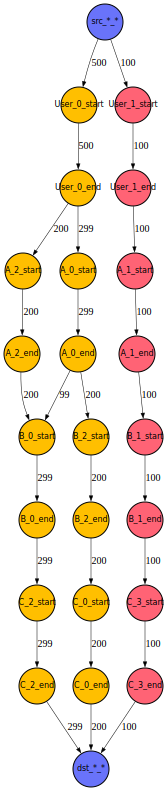

In [38]:
g_ = graphviz.Digraph()
# The node() method takes a name identifier as first argument and an optional label.
# The edge() method takes the names of start node and end node
# g_.size ="3,3"
print_all = True
node_pw = "1"
edge_pw = "0.5"
fs = "8"
edge_fs_0 = "10"
edge_fs_1 = "5"
fn="times bold italic"
edge_arrowsize="0.5"
edge_minlen="1"
c0_node_color = "#FFBF00"
c1_node_color = "#ff6375"
other_node_color = "#6973fa"

total_num_remote_routing = 0
if print_all:
    for k, v in aggregated_rps.items():
        src_replica_id = k[0].split("_")[1]
        dst_replica_id = k[1].split("_")[1]
        remote_routing = False
        if src_replica_id == '*' and dst_replica_id == '*':
            edge_color = "black"
            src_cid = -1
            dst_cid = -1
        elif src_replica_id == '*' and dst_replica_id != '*':
            edge_color = "black"
            src_cid = -1
            dst_cid = int(dst_replica_id)%2
        elif src_replica_id != '*' and dst_replica_id == '*':
            edge_color = "black"
            src_cid = int(src_replica_id)%2
            dst_cid = -1
        else:
            src_cid = int(src_replica_id)%2
            dst_cid = int(dst_replica_id)%2
            if src_cid == dst_cid:
                edge_color = "black" # local routing
            else:
                edge_color = "blue" # remote routing
                remote_routing = True
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            if src_cid == -1:
                src_node_color = other_node_color
            elif src_cid == 0:
                src_node_color = c0_node_color
            elif src_cid == 1:
                src_node_color = c1_node_color
            else:
                print("ERROR:  unsupported src_cid, ", src_cid)
                break
            if dst_cid == -1:
                dst_node_color = other_node_color
            elif dst_cid == 0:
                dst_node_color = c0_node_color
            elif dst_cid == 1:
                dst_node_color = c1_node_color
            else:
                print("ERROR: unsupported dst_cid, ", dst_cid)
                break
            print()
            g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=src_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=dst_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            if remote_routing:
                total_num_remote_routing += temp["Flow"].to_list()[0]
            g_.edge(k[0], k[1], label=str(int(temp["Flow"].to_list()[0])), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, fontcolor=edge_color, color=edge_color, arrowsize=edge_arrowsize, minlen=edge_minlen)
else:
    for k, v in aggregated_rps.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
        else:
            node_color = "#A7A4A4"
        g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.75")
        g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            # g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
            g_.edge(k[0], k[1], label=str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
        else:
            g_.edge(k[0], k[1], label=str(v), penwidth=edge_pw, style="dotted", fontsize=edge_fs_1, arrowhead="none", minlen=edge_minlen)
print("* total_num_remote_routing: ", total_num_remote_routing)
g_